In [1]:
# ================== 0. Imports & setup ==================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.manual_seed(42)
np.random.seed(42)

Device: cpu


In [3]:
# ================== 1. Load Fish Market regression data ==================
df = pd.read_csv("Fish.csv")  # Kaggle Fish Market

target_col = "Weight"
X_cols = [c for c in df.columns if c != target_col]

X = df[X_cols].copy()
if "Species" in X.columns:
    X = pd.get_dummies(X, columns=["Species"], drop_first=True)

X = X.values.astype(np.float32)
y = df[target_col].values.astype(np.float32).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_X.transform(X_train).astype(np.float32)
X_test_s  = scaler_X.transform(X_test).astype(np.float32)
y_train_s = scaler_y.transform(y_train).astype(np.float32)
y_test_s  = scaler_y.transform(y_test).astype(np.float32)

train_ds = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train_s))
test_ds  = TensorDataset(torch.from_numpy(X_test_s),  torch.from_numpy(y_test_s))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

input_dim  = X_train_s.shape[1]
output_dim = 1
print("Train size:", len(train_ds), "Test size:", len(test_ds))
print("Input dim:", input_dim)

Train size: 127 Test size: 32
Input dim: 11


In [5]:
# ================== 2. Model definitions ==================
class StandardNNReg(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class DropoutNNReg(nn.Module):
    def __init__(self, in_dim, out_dim, p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(p)
        self.out = nn.Linear(64, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.out(x)

class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_var=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w_mu  = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.w_rho = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-3.0))
        self.b_mu  = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.b_rho = nn.Parameter(torch.Tensor(out_features).fill_(-3.0))
        self.prior_var = prior_var
    def forward(self, x, sample=True):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        if self.training or sample:
            eps_w = torch.randn_like(self.w_mu)
            eps_b = torch.randn_like(self.b_mu)
            w = self.w_mu + w_sigma * eps_w
            b = self.b_mu + b_sigma * eps_b
        else:
            w = self.w_mu
            b = self.b_mu
        return F.linear(x, w, b)
    def kl_loss(self):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        kl_w = 0.5 * ((w_sigma**2 + self.w_mu**2)/self.prior_var - 1
                      + math.log(self.prior_var) - 2*torch.log(w_sigma.clamp(min=1e-8)))
        kl_b = 0.5 * ((b_sigma**2 + self.b_mu**2)/self.prior_var - 1
                      + math.log(self.prior_var) - 2*torch.log(b_sigma.clamp(min=1e-8)))
        return kl_w.sum() + kl_b.sum()

class VI_BBB_Reg(nn.Module):
    def __init__(self, in_dim, out_dim, prior_var=1.0):
        super().__init__()
        self.l1  = BayesLinear(in_dim, 128, prior_var=prior_var)
        self.l2  = BayesLinear(128, 64, prior_var=prior_var)
        self.out = BayesLinear(64, out_dim, prior_var=prior_var)
    def forward(self, x, sample=True):
        x = F.relu(self.l1(x, sample=sample))
        x = F.relu(self.l2(x, sample=sample))
        return self.out(x, sample=sample)
    def kl_loss(self):
        return self.l1.kl_loss() + self.l2.kl_loss() + self.out.kl_loss()

# PBP-style: same layers but tighter prior variance
class PBP_Reg(nn.Module):
    def __init__(self, in_dim, out_dim, prior_var=0.1):
        super().__init__()
        self.l1  = BayesLinear(in_dim, 128, prior_var=prior_var)
        self.l2  = BayesLinear(128, 64, prior_var=prior_var)
        self.out = BayesLinear(64, out_dim, prior_var=prior_var)
    def forward(self, x, sample=True):
        x = F.relu(self.l1(x, sample=sample))
        x = F.relu(self.l2(x, sample=sample))
        return self.out(x, sample=sample)
    def kl_loss(self):
        return self.l1.kl_loss() + self.l2.kl_loss() + self.out.kl_loss()


In [6]:
# ================== 3. Training helpers ==================
def train_epoch_reg(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def train_epoch_bayes(model, loader, optimizer, criterion, dataset_size):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, sample=True)
        ce = criterion(preds, yb)
        kl = model.kl_loss() / dataset_size
        loss = ce + kl
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_det(model, loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds.append(out)
            ys.append(yb.numpy())
    ys = np.concatenate(ys, axis=0)
    preds = np.concatenate(preds, axis=0)
    return ys, preds

def mc_dropout_reg_preds(model, loader, passes=30):
    model.train()  # keep dropout on
    ys_all, means_list, std_list = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            samples = []
            for _ in range(passes):
                out = model(xb).cpu().numpy()
                samples.append(out)
            samples = np.stack(samples, axis=0)   # [T,B,1]
            mean = samples.mean(axis=0)
            std  = samples.std(axis=0)
            means_list.append(mean)
            std_list.append(std)
            ys_all.append(yb.numpy())
    ys = np.concatenate(ys_all, axis=0)
    means = np.concatenate(means_list, axis=0)
    stds  = np.concatenate(std_list,  axis=0)
    return ys, means, stds

def bayes_reg_mc_preds(model, loader, passes=30):
    model.eval()
    ys_all, means_list, std_list = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            samples = []
            for _ in range(passes):
                out = model(xb, sample=True).cpu().numpy()
                samples.append(out)
            samples = np.stack(samples, axis=0)
            mean = samples.mean(axis=0)
            std  = samples.std(axis=0)
            means_list.append(mean)
            std_list.append(std)
            ys_all.append(yb.numpy())
    ys = np.concatenate(ys_all, axis=0)
    means = np.concatenate(means_list, axis=0)
    stds  = np.concatenate(std_list,  axis=0)
    return ys, means, stds

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))
def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))
def r2(y_true, y_pred):
    return float(r2_score(y_true, y_pred))

def gaussian_nll(y_true, mean, std):
    eps = 1e-6
    var = std**2 + eps
    return 0.5*(np.log(2*np.pi*var) + (y_true-mean)**2/var)


In [7]:
# ================== 4. Instantiate & train ==================
std_model  = StandardNNReg(input_dim, output_dim).to(device)
drop_model = DropoutNNReg(input_dim, output_dim, p=0.2).to(device)
vi_model   = VI_BBB_Reg(input_dim, output_dim, prior_var=1.0).to(device)
pbp_model  = PBP_Reg(input_dim, output_dim, prior_var=0.1).to(device)

criterion = nn.MSELoss()
opt_std   = optim.Adam(std_model.parameters(),   lr=1e-3)
opt_drop  = optim.Adam(drop_model.parameters(),  lr=1e-3)
opt_vi    = optim.Adam(vi_model.parameters(),    lr=1e-3)
opt_pbp   = optim.Adam(pbp_model.parameters(),   lr=1e-3)

epochs = 80
history = {k: [] for k in
           ["std_loss","drop_loss","vi_loss","pbp_loss"]}

for epoch in range(1, epochs+1):
    l_std  = train_epoch_reg(std_model,  train_loader, opt_std,  criterion)
    l_drop = train_epoch_reg(drop_model, train_loader, opt_drop, criterion)
    l_vi   = train_epoch_bayes(vi_model,  train_loader, opt_vi,  criterion, len(train_ds))
    l_pbp  = train_epoch_bayes(pbp_model, train_loader, opt_pbp, criterion, len(train_ds))

    history["std_loss"].append(l_std)
    history["drop_loss"].append(l_drop)
    history["vi_loss"].append(l_vi)
    history["pbp_loss"].append(l_pbp)

    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch:03d}/{epochs} | "
              f"Std {l_std:.4f} | Drop {l_drop:.4f} | "
              f"VI {l_vi:.4f} | PBP {l_pbp:.4f}")


Epoch 001/80 | Std 0.8002 | Drop 0.9808 | VI 197.4919 | PBP 112.3219
Epoch 010/80 | Std 0.0817 | Drop 0.1866 | VI 195.2326 | PBP 109.7290
Epoch 020/80 | Std 0.0274 | Drop 0.0780 | VI 193.5717 | PBP 107.4597
Epoch 030/80 | Std 0.0196 | Drop 0.0634 | VI 192.0702 | PBP 105.4843
Epoch 040/80 | Std 0.0165 | Drop 0.0419 | VI 190.5379 | PBP 103.5353
Epoch 050/80 | Std 0.0145 | Drop 0.0512 | VI 188.9738 | PBP 101.7147
Epoch 060/80 | Std 0.0134 | Drop 0.0468 | VI 187.4470 | PBP 99.9584
Epoch 070/80 | Std 0.0125 | Drop 0.0566 | VI 185.9757 | PBP 98.3083
Epoch 080/80 | Std 0.0119 | Drop 0.0397 | VI 184.4212 | PBP 96.7339


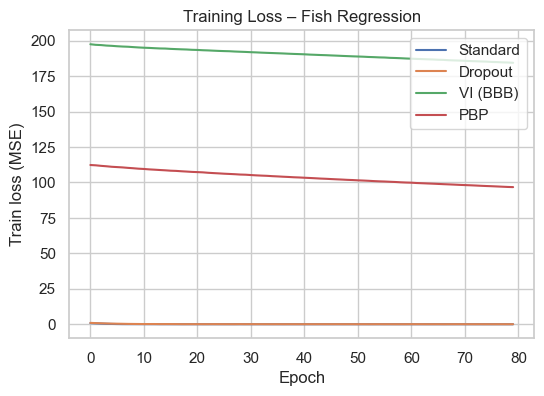

In [8]:
plt.figure(figsize=(6,4))
plt.plot(history["std_loss"],  label="Standard")
plt.plot(history["drop_loss"], label="Dropout")
plt.plot(history["vi_loss"],   label="VI (BBB)")
plt.plot(history["pbp_loss"],  label="PBP")
plt.xlabel("Epoch"); plt.ylabel("Train loss (MSE)")
plt.title("Training Loss – Fish Regression")
plt.legend(); plt.grid(True); plt.show()


In [9]:
# ================== 5. Predictions & rescaling ==================
y_std_s, std_preds_s  = eval_det(std_model,  test_loader)
_,       drop_means_s = eval_det(drop_model, test_loader)
y_mc_s,  mc_means_s,  mc_stds_s  = mc_dropout_reg_preds(drop_model, test_loader, passes=50)
y_vi_s,  vi_means_s,  vi_stds_s  = bayes_reg_mc_preds(vi_model,  test_loader, passes=50)
y_pbp_s, pbp_means_s, pbp_stds_s= bayes_reg_mc_preds(pbp_model, test_loader, passes=50)

# back to original scale
y_test_orig = scaler_y.inverse_transform(y_std_s)
std_preds   = scaler_y.inverse_transform(std_preds_s)
drop_means  = scaler_y.inverse_transform(drop_means_s)
mc_means    = scaler_y.inverse_transform(mc_means_s)
vi_means    = scaler_y.inverse_transform(vi_means_s)
pbp_means   = scaler_y.inverse_transform(pbp_means_s)

target_var  = scaler_y.var_
mc_stds  = mc_stds_s  * np.sqrt(target_var)
vi_stds  = vi_stds_s  * np.sqrt(target_var)
pbp_stds = pbp_stds_s * np.sqrt(target_var)


In [11]:
# ================== 6. Basic point metrics ==================
for name, pred in [
    ("Standard NN", std_preds),
    #("Dropout NN",  drop_means),
    ("MC Dropout",  mc_means),
    ("VI (BBB)",    vi_means),
    ("PBP",         pbp_means),
]:
    print(name, {
        "RMSE": rmse(y_test_orig, pred),
        "MAE":  mae(y_test_orig, pred),
        "R2":   r2(y_test_orig, pred)
    })


Standard NN {'RMSE': 52.38880157470703, 'MAE': 36.88255310058594, 'R2': 0.9807044400477325}
MC Dropout {'RMSE': 58.77631759643555, 'MAE': 40.613372802734375, 'R2': 0.9757123690050645}
VI (BBB) {'RMSE': 57.851043701171875, 'MAE': 36.49033737182617, 'R2': 0.9764710333538422}
PBP {'RMSE': 64.01335144042969, 'MAE': 46.8632926940918, 'R2': 0.9711914386303314}


In [12]:
def eval_regression_model(y_true, mean_fn, std_fn, passes=30):
    rmses, lls = [], []
    for _ in range(passes):
        mean = mean_fn().ravel()
        std  = std_fn().ravel()
        rmses.append(rmse(y_true.ravel(), mean))
        ll = -gaussian_nll(y_true.ravel(), mean, std).mean()
        lls.append(float(ll))
    return np.array(rmses), np.array(lls)

# wrappers using existing arrays (no retrain)
def mc_mean_fn():  return mc_means
def mc_std_fn():   return mc_stds
def vi_mean_fn():  return vi_means
def vi_std_fn():   return vi_stds
def pbp_mean_fn(): return pbp_means
def pbp_std_fn():  return pbp_stds

print("MC Dropout")
mc_r, mc_ll = eval_regression_model(y_test_orig, mc_mean_fn, mc_std_fn, passes=30)
print(f"  Avg Test RMSE: {mc_r.mean():.4f} ± {mc_r.std():.4f}")
print(f"  Avg Test LL  : {mc_ll.mean():.4f} ± {mc_ll.std():.4f}\n")

print("BBB (Variational Inference)")
vi_r, vi_ll = eval_regression_model(y_test_orig, vi_mean_fn, vi_std_fn, passes=30)
print(f"  Avg Test RMSE: {vi_r.mean():.4f} ± {vi_r.std():.4f}")
print(f"  Avg Test LL  : {vi_ll.mean():.4f} ± {vi_ll.std():.4f}\n")

print("Probabilistic Backprop")
pbp_r, pbp_ll = eval_regression_model(y_test_orig, pbp_mean_fn, pbp_std_fn, passes=30)
print(f"  Avg Test RMSE: {pbp_r.mean():.4f} ± {pbp_r.std():.4f}")
print(f"  Avg Test LL  : {pbp_ll.mean():.4f} ± {pbp_ll.std():.4f}")


MC Dropout
  Avg Test RMSE: 58.7763 ± 0.0000
  Avg Test LL  : -5.3314 ± 0.0000

BBB (Variational Inference)
  Avg Test RMSE: 57.8510 ± 0.0000
  Avg Test LL  : -5.4281 ± 0.0000

Probabilistic Backprop
  Avg Test RMSE: 64.0134 ± 0.0000
  Avg Test LL  : -5.4552 ± 0.0000


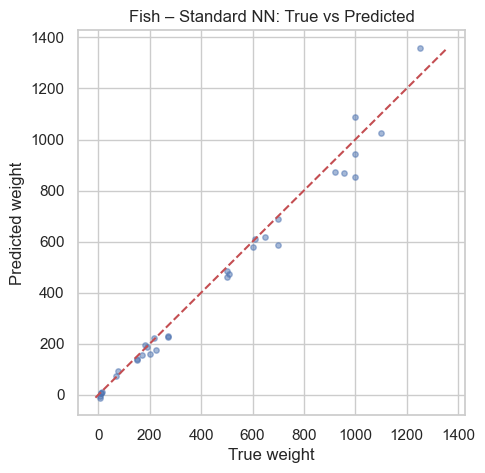

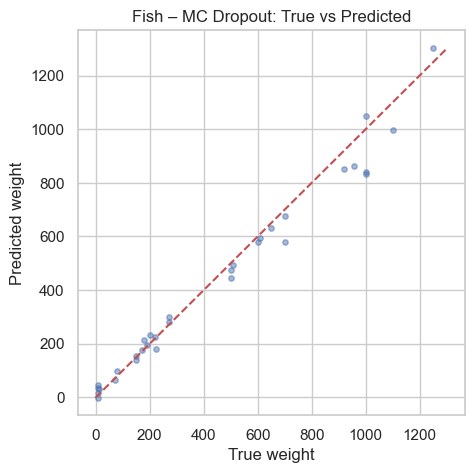

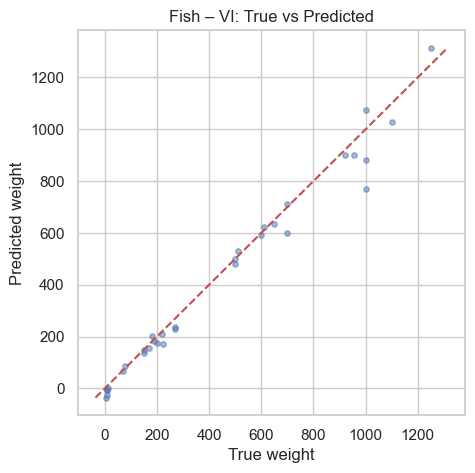

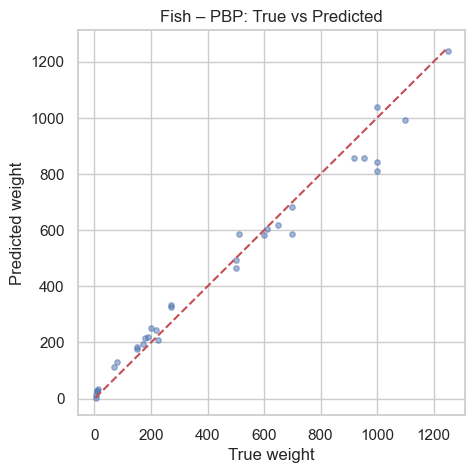

In [13]:
def scatter_true_pred(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=15, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, "r--")
    plt.xlabel("True weight"); plt.ylabel("Predicted weight")
    plt.title(title); plt.grid(True); plt.show()

scatter_true_pred(y_test_orig, std_preds, "Fish – Standard NN: True vs Predicted")
scatter_true_pred(y_test_orig, mc_means,  "Fish – MC Dropout: True vs Predicted")
scatter_true_pred(y_test_orig, vi_means,  "Fish – VI: True vs Predicted")
scatter_true_pred(y_test_orig, pbp_means, "Fish – PBP: True vs Predicted")


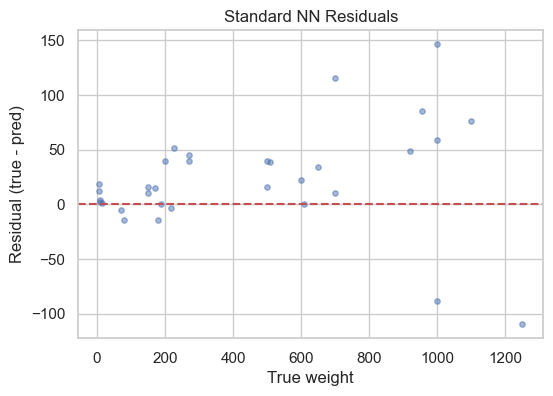

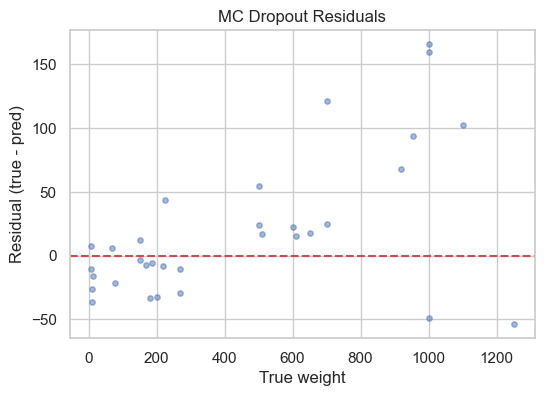

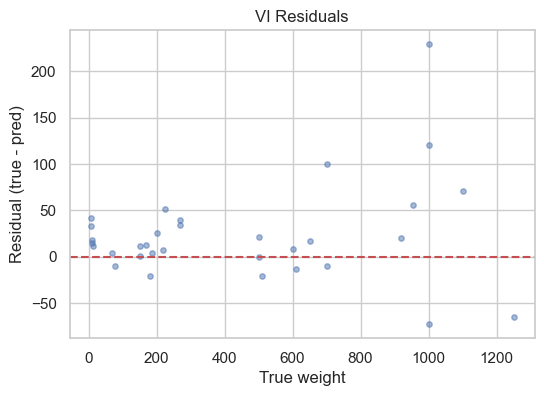

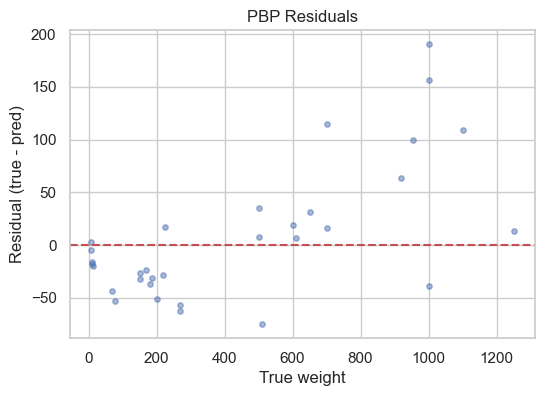

In [15]:
def residual_plot(y_true, y_pred, title):
    resid = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, resid, s=15, alpha=0.5)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel("True weight"); plt.ylabel("Residual (true - pred)")
    plt.title(title); plt.grid(True); plt.show()

residual_plot(y_test_orig, std_preds, "Standard NN Residuals")
residual_plot(y_test_orig, mc_means,  "MC Dropout Residuals")
residual_plot(y_test_orig, vi_means,  "VI Residuals")
residual_plot(y_test_orig, pbp_means, "PBP Residuals")


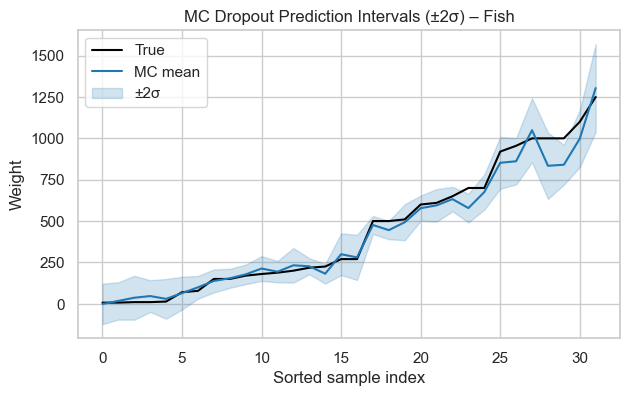

In [16]:
idx = np.argsort(y_test_orig.ravel())
y_sorted      = y_test_orig.ravel()[idx]
mc_mean_sort  = mc_means.ravel()[idx]
mc_std_sort   = mc_stds.ravel()[idx]

plt.figure(figsize=(7,4))
plt.plot(y_sorted, label="True", color="black")
plt.plot(mc_mean_sort, label="MC mean", color="tab:blue")
plt.fill_between(np.arange(len(y_sorted)),
                 mc_mean_sort - 2*mc_std_sort,
                 mc_mean_sort + 2*mc_std_sort,
                 color="tab:blue", alpha=0.2, label="±2σ")
plt.xlabel("Sorted sample index")
plt.ylabel("Weight")
plt.title("MC Dropout Prediction Intervals (±2σ) – Fish")
plt.legend(); plt.grid(True); plt.show()


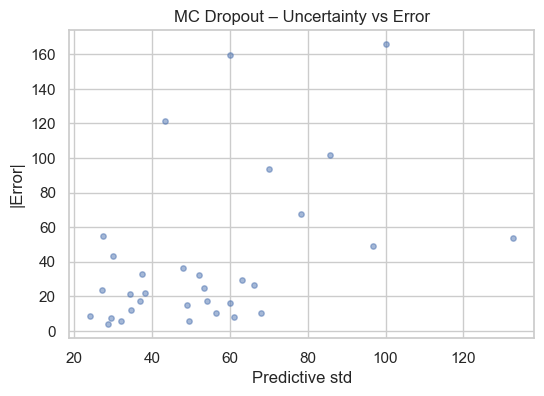

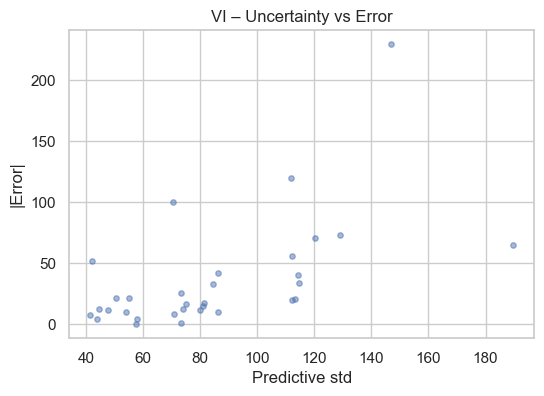

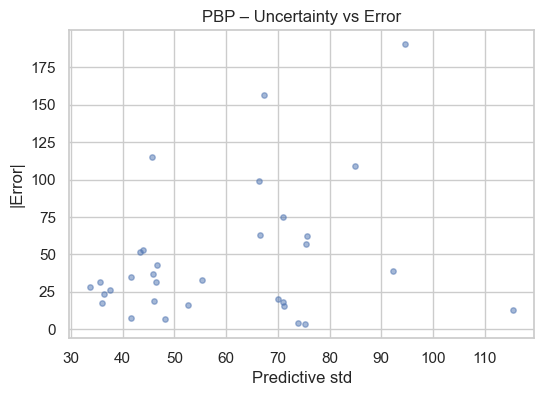

In [17]:
def uncert_vs_error(y_true, mean, std, title):
    err = np.abs(y_true.ravel() - mean.ravel())
    plt.figure(figsize=(6,4))
    plt.scatter(std.ravel(), err, s=15, alpha=0.5)
    plt.xlabel("Predictive std"); plt.ylabel("|Error|")
    plt.title(title); plt.grid(True); plt.show()

uncert_vs_error(y_test_orig, mc_means,  mc_stds,  "MC Dropout – Uncertainty vs Error")
uncert_vs_error(y_test_orig, vi_means,  vi_stds,  "VI – Uncertainty vs Error")
uncert_vs_error(y_test_orig, pbp_means, pbp_stds, "PBP – Uncertainty vs Error")


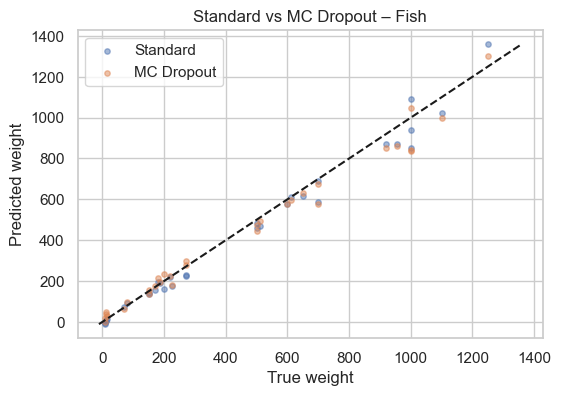

In [18]:
plt.figure(figsize=(6,4))
plt.scatter(y_test_orig, std_preds, s=15, alpha=0.5, label="Standard")
plt.scatter(y_test_orig, mc_means,  s=15, alpha=0.5, label="MC Dropout")
lims = [min(y_test_orig.min(), std_preds.min(), mc_means.min()),
        max(y_test_orig.max(), std_preds.max(), mc_means.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True weight"); plt.ylabel("Predicted weight")
plt.title("Standard vs MC Dropout – Fish")
plt.legend(); plt.grid(True); plt.show()


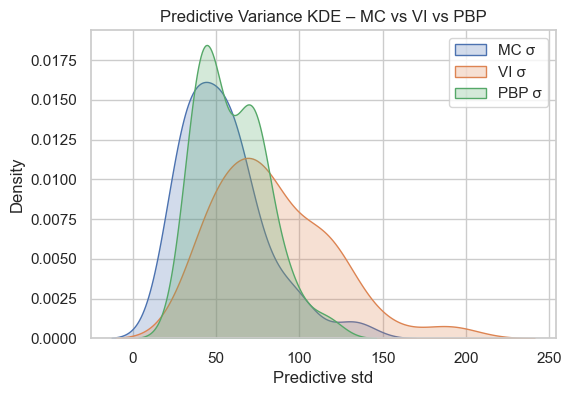

In [20]:
plt.figure(figsize=(6,4))
sns.kdeplot(mc_stds.ravel(),  label="MC σ",  fill=True)
sns.kdeplot(vi_stds.ravel(),  label="VI σ",  fill=True)
sns.kdeplot(pbp_stds.ravel(), label="PBP σ", fill=True)
plt.xlabel("Predictive std"); plt.ylabel("Density")
plt.title("Predictive Variance KDE – MC vs VI vs PBP")
plt.legend(); plt.grid(True); plt.show()


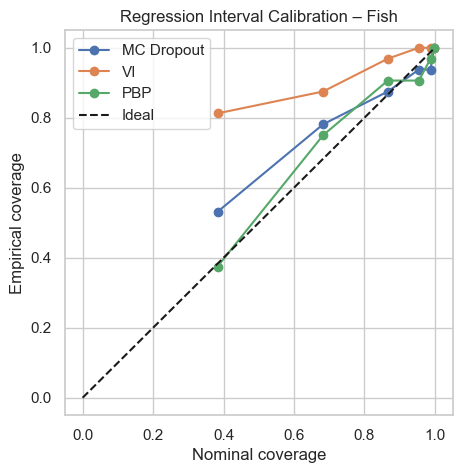

In [21]:
def interval_coverage(y_true, mean, std, k):
    lower = mean - k*std
    upper = mean + k*std
    inside = (y_true >= lower) & (y_true <= upper)
    return inside.mean()

k_vals = np.linspace(0.5, 3.0, 6)
from math import erf, sqrt

def coverage_curve(y_true, mean, std, name):
    emp = [interval_coverage(y_true, mean, std, k) for k in k_vals]
    nom = [erf(k/(sqrt(2))) for k in k_vals]
    plt.plot(nom, emp, "o-", label=name)

plt.figure(figsize=(5,5))
coverage_curve(y_test_orig, mc_means,  mc_stds,  "MC Dropout")
coverage_curve(y_test_orig, vi_means,  vi_stds,  "VI")
coverage_curve(y_test_orig, pbp_means, pbp_stds, "PBP")
plt.plot([0,1],[0,1],"k--",label="Ideal")
plt.xlabel("Nominal coverage")
plt.ylabel("Empirical coverage")
plt.title("Regression Interval Calibration – Fish")
plt.legend(); plt.grid(True); plt.show()


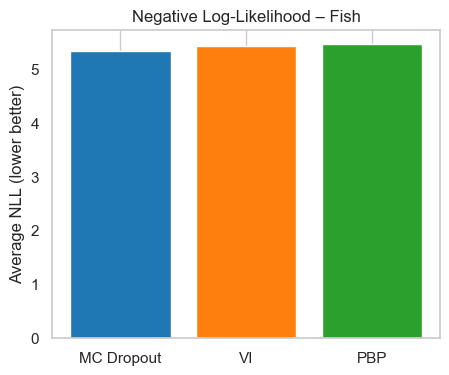

In [22]:
nll_mc  = -gaussian_nll(y_test_orig.ravel(), mc_means.ravel(),  mc_stds.ravel()).mean()
nll_vi  = -gaussian_nll(y_test_orig.ravel(), vi_means.ravel(),  vi_stds.ravel()).mean()
nll_pbp = -gaussian_nll(y_test_orig.ravel(), pbp_means.ravel(), pbp_stds.ravel()).mean()

plt.figure(figsize=(5,4))
plt.bar(["MC Dropout","VI","PBP"], [-nll_mc,-nll_vi,-nll_pbp],
        color=["tab:blue","tab:orange","tab:green"])
plt.ylabel("Average NLL (lower better)")
plt.title("Negative Log-Likelihood – Fish")
plt.grid(axis="y"); plt.show()


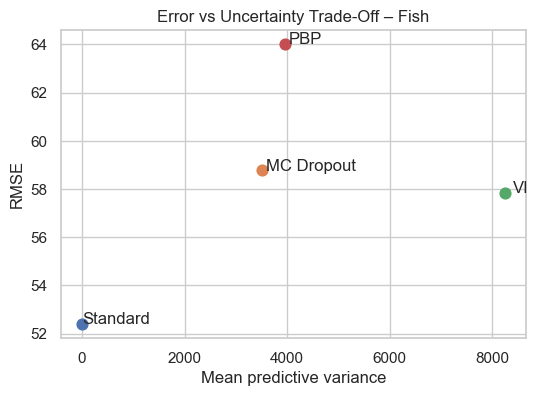

In [23]:
models_reg = {
    "Standard": (std_preds.ravel(), np.zeros_like(std_preds.ravel())),
    "MC Dropout": (mc_means.ravel(), mc_stds.ravel()),
    "VI":         (vi_means.ravel(), vi_stds.ravel()),
    "PBP":        (pbp_means.ravel(), pbp_stds.ravel())
}

errs, vars_, names = [], [], []
for name, (mean, std) in models_reg.items():
    errs.append(rmse(y_test_orig.ravel(), mean))
    vars_.append((std**2).mean())
    names.append(name)

plt.figure(figsize=(6,4))
for e,v,n in zip(errs,vars_,names):
    plt.scatter(v,e,s=60)
    plt.text(v*1.02, e, n)
plt.xlabel("Mean predictive variance")
plt.ylabel("RMSE")
plt.title("Error vs Uncertainty Trade-Off – Fish")
plt.grid(True); plt.show()


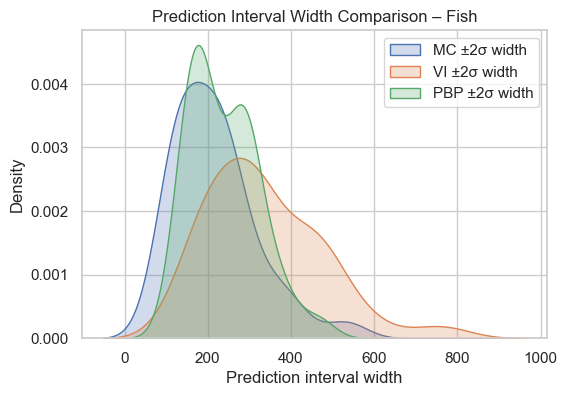

In [25]:
width_mc  = 4*mc_stds.ravel()
width_vi  = 4*vi_stds.ravel()
width_pbp = 4*pbp_stds.ravel()

plt.figure(figsize=(6,4))
sns.kdeplot(width_mc,  label="MC ±2σ width",  fill=True)
sns.kdeplot(width_vi,  label="VI ±2σ width",  fill=True)
sns.kdeplot(width_pbp, label="PBP ±2σ width", fill=True)
plt.xlabel("Prediction interval width")
plt.ylabel("Density")
plt.title("Prediction Interval Width Comparison – Fish")
plt.legend(); plt.grid(True); plt.show()
